# Data Science Project

* Name: Author Name
* Email:


## TABLE OF CONTENTS 


- **[Introduction](#INTRODUCTION)<br>**
- **[OBTAIN](#OBTAIN)**<br>
- **[SCRUB](#SCRUB)**<br>
- **[EXPLORE](#EXPLORE)**<br>
- **[MODEL](#MODEL)**<br>
- **[iNTERPRET](#iNTERPRET)**<br>
- **[Conclusions/Recommendations](#CONCLUSIONS-&-RECOMMENDATIONS)<br>**
___

# INTRODUCTION

> Explain the point of your project and what question you are trying to answer with your modeling.



In [146]:
from distutils.util import strtobool
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib import ticker
import seaborn as sns
import missingno as msno

sns.set_theme(font_scale=1, style='darkgrid')
sns.set_palette("deep", desat=0.85, color_codes=True)
%matplotlib inline

In [147]:
%load_ext autoreload
%autoreload 2
from tools import cleaning, outliers, plotting, utils
from tools.modeling import diagnostics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# OBTAIN

In [148]:
df = pd.read_csv("data/bank-additional-full.csv", sep=";")
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [150]:
df.nunique()

age                 78
job                 12
marital              4
education            8
default              3
housing              3
loan                 3
contact              2
month               10
day_of_week          5
duration          1544
campaign            42
pdays               27
previous             8
poutcome             3
emp.var.rate        10
cons.price.idx      26
cons.conf.idx       26
euribor3m          316
nr.employed         11
y                    2
dtype: int64

# SCRUB

I rename some features to make them a little easier to interpret. Every variable prefixed with "contact" has to do with the last contact of the current campaign.

In [151]:
df.columns = df.columns.str.replace(".", "_", regex=False)
rename = {"y": "invested",
        "poutcome": "prev_outcome",
        "pdays": "days_since_prev",
        "previous": "prev_contact_count",
        "campaign": "contact_count",
        "month": "contact_month",
        "day_of_week": "contact_weekday",
        "duration": "contact_duration",
        "contact": "contact_type",
        "nr_employed": "n_employed",
        "euribor3m": "euribor_3m"}
df.rename(columns=rename, inplace=True)
del rename
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact_type', 'contact_month', 'contact_weekday', 'contact_duration',
       'contact_count', 'days_since_prev', 'prev_contact_count',
       'prev_outcome', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx',
       'euribor_3m', 'n_employed', 'invested'],
      dtype='object')

In [152]:
df["days_since_prev"].replace(999, np.NaN, inplace=True)
df.replace(["unknown", "nonexistent"], np.NaN, inplace=True)
cleaning.info(df)

,nan,nan_%,uniq,uniq_%,dup,dup_%
days_since_prev,39673,96.32,26,0.06,12,0.03
prev_outcome,35563,86.34,2,0.00,12,0.03
default,8597,20.87,2,0.00,12,0.03
education,1731,4.20,7,0.02,12,0.03
housing,990,2.40,2,0.00,12,0.03
loan,990,2.40,2,0.00,12,0.03
job,330,0.80,11,0.03,12,0.03
marital,80,0.19,3,0.01,12,0.03
age,0,0.00,78,0.19,12,0.03
n_employed,0,0.00,11,0.03,12,0.03


In [153]:
display(df.loc[df.duplicated()])
df.drop_duplicates(inplace=True)

,age,job,marital,education,default,housing,loan,contact_type,contact_month,contact_weekday,...,contact_count,days_since_prev,prev_contact_count,prev_outcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,n_employed,invested
1266,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,...,1,NaN,0,NaN,1.1,93.994,-36.4,4.855,5191.0,no
12261,36,retired,married,NaN,no,no,no,telephone,jul,thu,...,1,NaN,0,NaN,1.4,93.918,-42.7,4.966,5228.1,no
14234,27,technician,single,professional.course,no,no,no,cellular,jul,mon,...,2,NaN,0,NaN,1.4,93.918,-42.7,4.962,5228.1,no
16956,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,...,3,NaN,0,NaN,1.4,93.918,-42.7,4.962,5228.1,no
18465,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,...,1,NaN,0,NaN,1.4,93.918,-42.7,4.968,5228.1,no
20216,55,services,married,high.school,NaN,no,no,cellular,aug,mon,...,1,NaN,0,NaN,1.4,93.444,-36.1,4.965,5228.1,no
20534,41,technician,married,professional.course,no,yes,no,cellular,aug,tue,...,1,NaN,0,NaN,1.4,93.444,-36.1,4.966,5228.1,no
25217,39,admin.,married,university.degree,no,no,no,cellular,nov,tue,...,2,NaN,0,NaN,-0.1,93.200,-42.0,4.153,5195.8,no
28477,24,services,single,high.school,no,yes,no,cellular,apr,tue,...,1,NaN,0,NaN,-1.8,93.075,-47.1,1.423,5099.1,no
32516,35,admin.,married,university.degree,no,yes,no,cellular,may,fri,...,4,NaN,0,NaN,-1.8,92.893,-46.2,1.313,5099.1,no


In [154]:
cleaning.show_uniques(df, cut=20)

job,marital,education,default,housing,loan,contact_type,contact_month,contact_weekday,prev_contact_count,prev_outcome,emp_var_rate,n_employed,invested
housemaid,married,basic.4y,no,no,no,telephone,may,mon,0.0,failure,1.1,5191.0,no
services,single,high.school,yes,yes,yes,cellular,jun,tue,1.0,success,1.4,5228.1,yes
admin.,divorced,basic.6y,,,,,jul,wed,2.0,,-0.1,5195.8,
blue-collar,,basic.9y,,,,,aug,thu,3.0,,-0.2,5176.3,
technician,,professional.course,,,,,oct,fri,4.0,,-1.8,5099.1,
retired,,university.degree,,,,,nov,,5.0,,-2.9,5076.2,
management,,illiterate,,,,,dec,,6.0,,-3.4,5017.5,
unemployed,,,,,,,mar,,7.0,,-3.0,5023.5,
self-employed,,,,,,,apr,,,,-1.7,5008.7,
entrepreneur,,,,,,,sep,,,,-1.1,4991.6,


<AxesSubplot:>

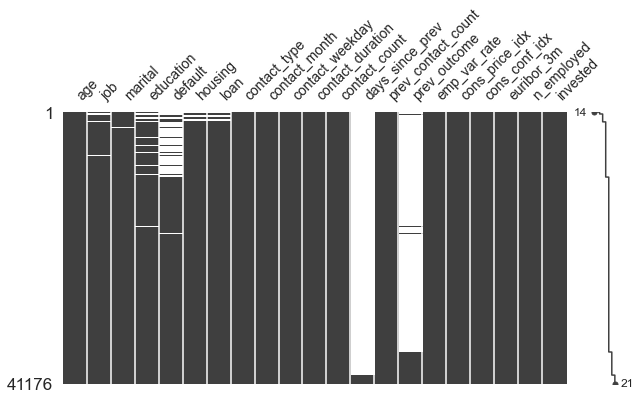

In [155]:
msno.matrix(df, figsize=(10, 5), sort="ascending", fontsize=14)

I go ahead and encode "invested" as a boolean for convenience. It's the prediction target and I'll need to make calculations for EDA.

In [156]:
df["invested"] = (df["invested"] == "yes").astype(np.float64)
df["invested"].value_counts(normalize=True)

0.0    0.887337
1.0    0.112663
Name: invested, dtype: float64

In [157]:
df["prev_success"] = df["prev_outcome"].map(
    lambda x: x == "success", "ignore").astype(np.float64)

df.drop(columns="prev_outcome", inplace=True)

df["prev_success"].value_counts(1)

0.0    0.755911
1.0    0.244089
Name: prev_success, dtype: float64

In [168]:
outliers.tukey_outliers(df["days_since_prev"]).value_counts()

False    41094
True        82
Name: days_since_prev, dtype: int64

One week seems like a good cutoff for turning "days_since_prev" into a categorical. I will leave the NaNs to be imputed later.

1.0    0.776898
0.0    0.223102
Name: recent_prev_contact, dtype: float64

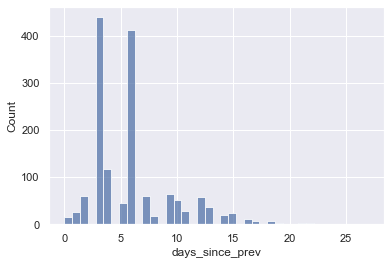

In [86]:
sns.histplot(data=df, x="days_since_prev")

df["recent_prev_contact"] = df["days_since_prev"].map(
    lambda x: x <= 7, "ignore").astype(np.float64)

df.drop(columns="days_since_prev", inplace=True)

df["recent_prev_contact"].value_counts(1)

I turn "prev_contact_count" into a binary categorical because values over 

In [145]:
# sns.histplot(data=df, x="prev_contact_count")
# df.rename({"prev_contact_count": "prev_contact"}, axis=1, inplace=True)
# df["prev_contact"] = df["prev_contact"].astype(np.bool_).astype(np.float64)
# df["prev_contact"].value_counts(1)
# outliers.z_winsorize(df["prev_contact_count"]).plot.hist()
# df.quantile([0.05, 0.95])

False    1.0
Name: recent_prev_contact, dtype: float64

I convert the binary "contact_type" feature to a boolean feature "contact_cellular". Again, every variable with the "contact" prefix has to do with the last contact of the current campaign.

In [14]:
df["contact_cellular"] = (df["contact_type"] == "cellular").astype(np.float64)
df.drop(columns="contact_type", inplace=True)
df["contact_cellular"].value_counts()

1.0    26135
0.0    15041
Name: contact_cellular, dtype: int64

I go ahead and numerically encode these binary string categoricals, preserving NaNs.

In [15]:
string_cols = ["default", "housing", "loan"]
df[string_cols] = df[string_cols].applymap(strtobool, "ignore")
cleaning.show_uniques(df, columns=string_cols)
del string_cols

default,housing,loan
0.0,0.0,0.0
1.0,1.0,1.0


For now I will hold off on converting these binary variables to categorical dtype. It will be easier to work with them as numeric variables, since they don't need to be one-hot encoded.

In [16]:
binary_cats = utils.binary_cols(df)
df[binary_cats] = df[binary_cats].astype(np.float64)
cleaning.show_uniques(df, columns=binary_cats)

default,housing,loan,invested,prev_success,recent_prev_contact,contact_cellular
0.0,0.0,0.0,0.0,0.0,1.0,0.0
1.0,1.0,1.0,1.0,1.0,0.0,1.0


Looks like most of the binary categoricals are imbalanced.

In [17]:
cleaning.token_info(df[binary_cats], normalize=True)

,min_tokens,max_tokens,types
default,0.000092,0.999908,2.0
invested,0.112663,0.887337,2.0
loan,0.155477,0.844523,2.0
recent_prev_contact,0.223102,0.776898,2.0
prev_success,0.244089,0.755911,2.0
contact_cellular,0.365286,0.634714,2.0
housing,0.463221,0.536779,2.0


 I drop the most extremely imbalanced binaries: "default" and "prev_callback_over_1w". These had a minority class of less than 1% of the sample.

In [18]:
df.drop(columns=["default"], inplace=True)
del binary_cats
cleaning.token_info(df.loc[:, df.nunique() == 2], normalize=True)

,min_tokens,max_tokens,types
invested,0.112663,0.887337,2.0
loan,0.155477,0.844523,2.0
recent_prev_contact,0.223102,0.776898,2.0
prev_success,0.244089,0.755911,2.0
contact_cellular,0.365286,0.634714,2.0
housing,0.463221,0.536779,2.0


In [19]:
multi_cat = ["job", "marital", "education", "contact_month", "contact_weekday"]

# tweak some labels
df["job"] = df["job"].str.replace(".", "", regex=False)
df["job"] = df["job"].str.replace("-", "_", regex=False)
df["education"] = df["education"].str.replace(".", "_", regex=False)

# convert to unordered categoricals
df[multi_cat] = df[multi_cat].astype("category")



cleaning.show_uniques(df, columns=multi_cat)

job,marital,education,contact_month,contact_weekday
housemaid,married,basic_4y,may,mon
services,single,high_school,jun,tue
admin,divorced,basic_6y,jul,wed
blue_collar,,basic_9y,aug,thu
technician,,professional_course,oct,fri
retired,,university_degree,nov,
management,,illiterate,dec,
unemployed,,,mar,
self_employed,,,apr,
entrepreneur,,,sep,


The class balance looks serviceable, but there are a couple extremely thin classes (under 1%): "dec" and "illiterate".

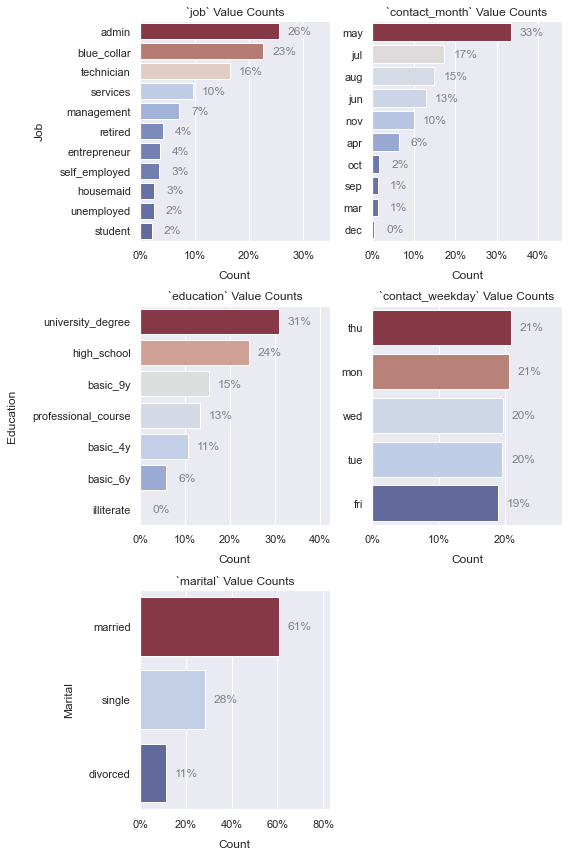

In [20]:
plotting.multi_countplot(df[multi_cat], normalize=True, ncols=2, sp_height=4);
del multi_cat

I drop the extremely thin "illiterate" and "dec" classes.

In [21]:
# compute rows to keep
keep = (df.education != "illiterate") & (df.contact_month != "dec")

# overwrite `df` with keeper rows
df = df.loc[keep].copy()

# drop unused categories
df["education"] = df["education"].cat.remove_unused_categories()
df["contact_month"] = df["contact_month"].cat.remove_unused_categories()

# view results
print(f"Dropped {(~keep).sum()} observations.")
del keep
cleaning.token_info(df[["education", "contact_month"]], normalize=True)

Dropped 200 observations.


,min_tokens,max_tokens,types
contact_month,0.013325,0.335904,9.0
education,0.058355,0.308049,6.0


I order the weekdays and months for plotting purposes.

In [22]:
# define order
days = ["mon", "tue", "wed", "thu", "fri"]
months = ["mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov"]

# convert to ordered categories
df["contact_weekday"].cat.reorder_categories(days, ordered=True, inplace=True)
df["contact_month"].cat.reorder_categories(months, ordered=True, inplace=True)

# mop up temp variables
del days, months

display(df["contact_weekday"].cat.categories)
display(df["contact_month"].cat.categories)

Index(['mon', 'tue', 'wed', 'thu', 'fri'], dtype='object')

Index(['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov'], dtype='object')

# EXPLORE

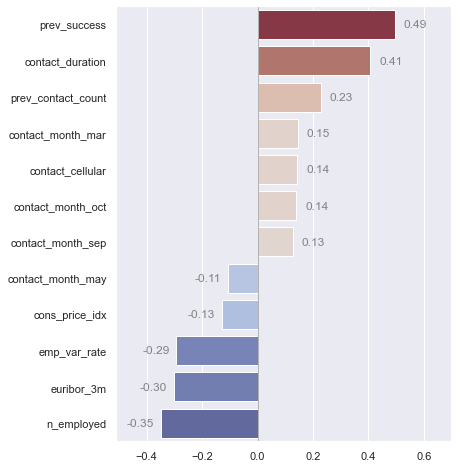

In [23]:
inv_corr = pd.get_dummies(df.drop(columns="invested"))
inv_corr = inv_corr.corrwith(df["invested"])
inv_corr = inv_corr.loc[inv_corr.abs() > .1]
ax = plotting.heated_barplot(inv_corr)
plotting.annot_bars(ax)
del inv_corr, ax

<AxesSubplot:title={'center':'Correlations Between Features'}>

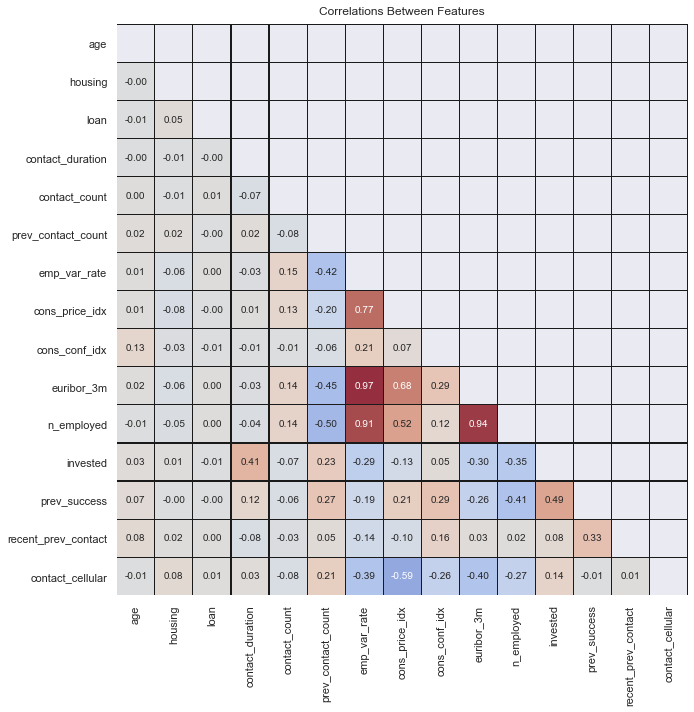

In [24]:
plotting.pair_corr_heatmap(df, scale=.7)

<AxesSubplot:title={'center':'Correlation with Numeric Features'}, xlabel='Numeric Features', ylabel='Categorical Features'>

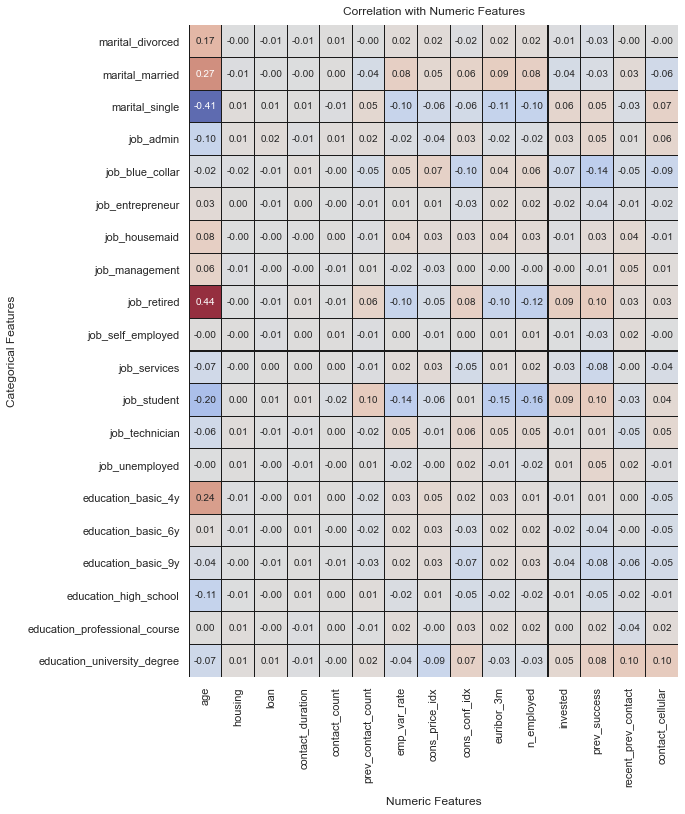

In [25]:
plotting.cat_corr_heatmap(
    df, ["marital", "job", "education"], scale=.6, fmt=".2f")

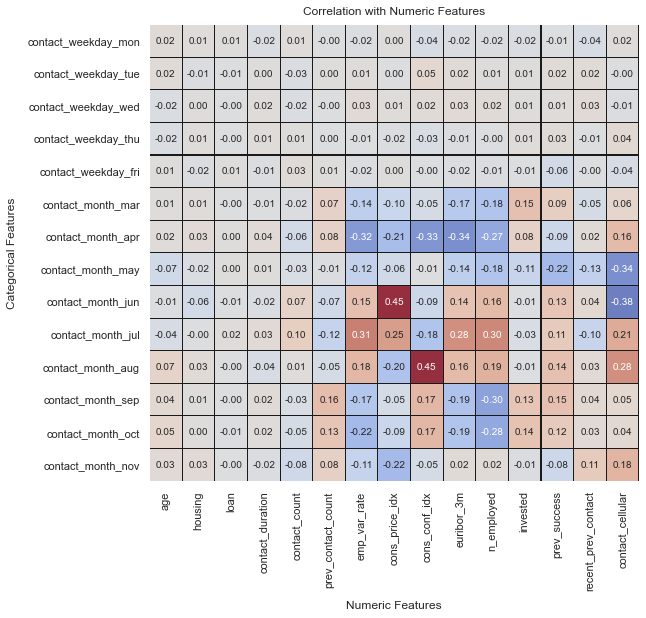

In [26]:
temporal = ["contact_weekday", "contact_month"]
plotting.cat_corr_heatmap(df, temporal, scale=.6, fmt=".2f")
del temporal

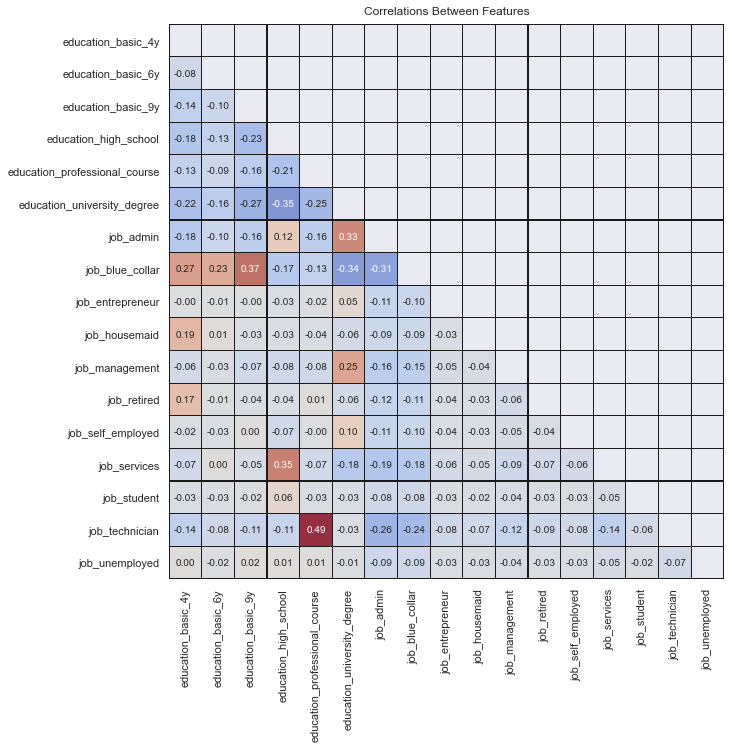

In [27]:
dummies = pd.get_dummies(df[["education", "job"]])
plotting.pair_corr_heatmap(dummies, scale=.6, fmt=".2f")
del dummies

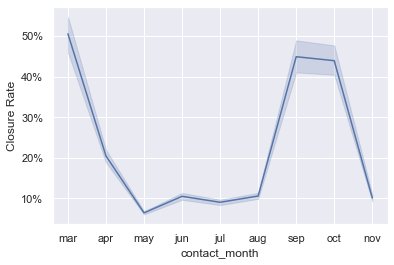

In [28]:
ax = sns.lineplot(data=df, x="contact_month", y="invested")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax.set_ylabel("Closure Rate")
del ax

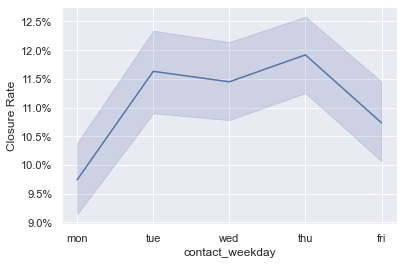

In [29]:
ax = sns.lineplot(data=df, x="contact_weekday", y="invested")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))
ax.set_ylabel("Closure Rate")
del ax

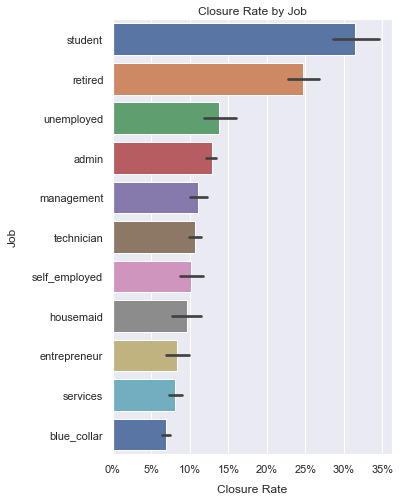

In [30]:
ax = plotting.simple_barplot(df, "job", "invested", sort="desc", orient="h", palette="deep")
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax.set_xlabel("Closure Rate", labelpad=10)
ax.set_title("Closure Rate by Job", pad=5)
del ax

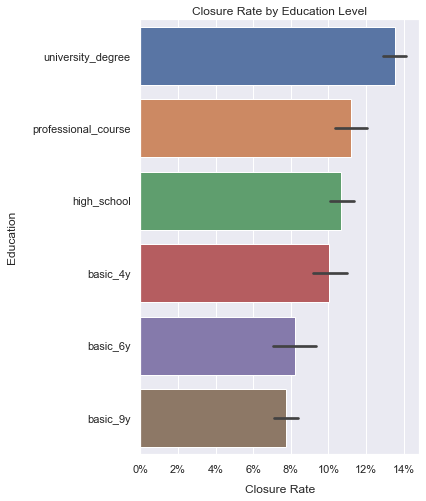

In [31]:
ax = plotting.simple_barplot(df, "education", "invested", sort="desc", orient="h", palette="deep")
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax.set_xlabel("Closure Rate", labelpad=10)
ax.set_title("Closure Rate by Education Level", pad=5)
del ax

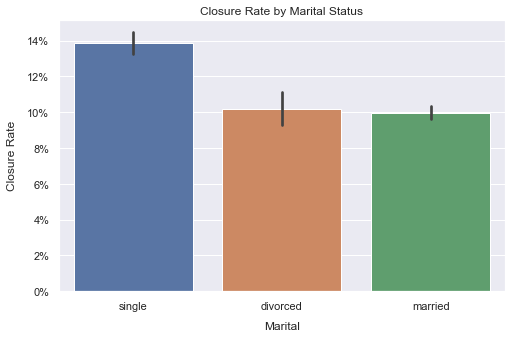

In [32]:
ax = plotting.simple_barplot(df, "marital", "invested", sort="desc", orient="v", palette="deep")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax.set_ylabel("Closure Rate", labelpad=10)
ax.set_title("Closure Rate by Marital Status", pad=5)
del ax

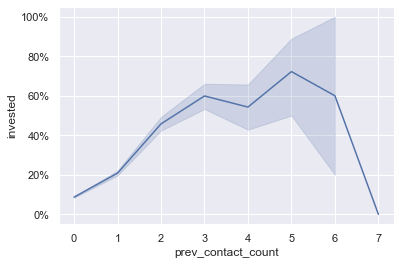

In [33]:
ax = sns.lineplot(data=df, x="prev_contact_count", y="invested")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
del ax

array([[<AxesSubplot:title={'center':'Distribution of `age`'}, xlabel='age', ylabel='Count'>,
        <AxesSubplot:title={'center':'Distribution of `contact_duration`'}, xlabel='contact_duration'>,
        <AxesSubplot:title={'center':'Distribution of `contact_count`'}, xlabel='contact_count'>],
       [<AxesSubplot:title={'center':'Distribution of `prev_contact_count`'}, xlabel='prev_contact_count', ylabel='Count'>,
        <AxesSubplot:title={'center':'Distribution of `emp_var_rate`'}, xlabel='emp_var_rate'>,
        <AxesSubplot:title={'center':'Distribution of `cons_price_idx`'}, xlabel='cons_price_idx'>],
       [<AxesSubplot:title={'center':'Distribution of `cons_conf_idx`'}, xlabel='cons_conf_idx', ylabel='Count'>,
        <AxesSubplot:title={'center':'Distribution of `euribor_3m`'}, xlabel='euribor_3m'>,
        <AxesSubplot:title={'center':'Distribution of `n_employed`'}, xlabel='n_employed'>]],
      dtype=object)

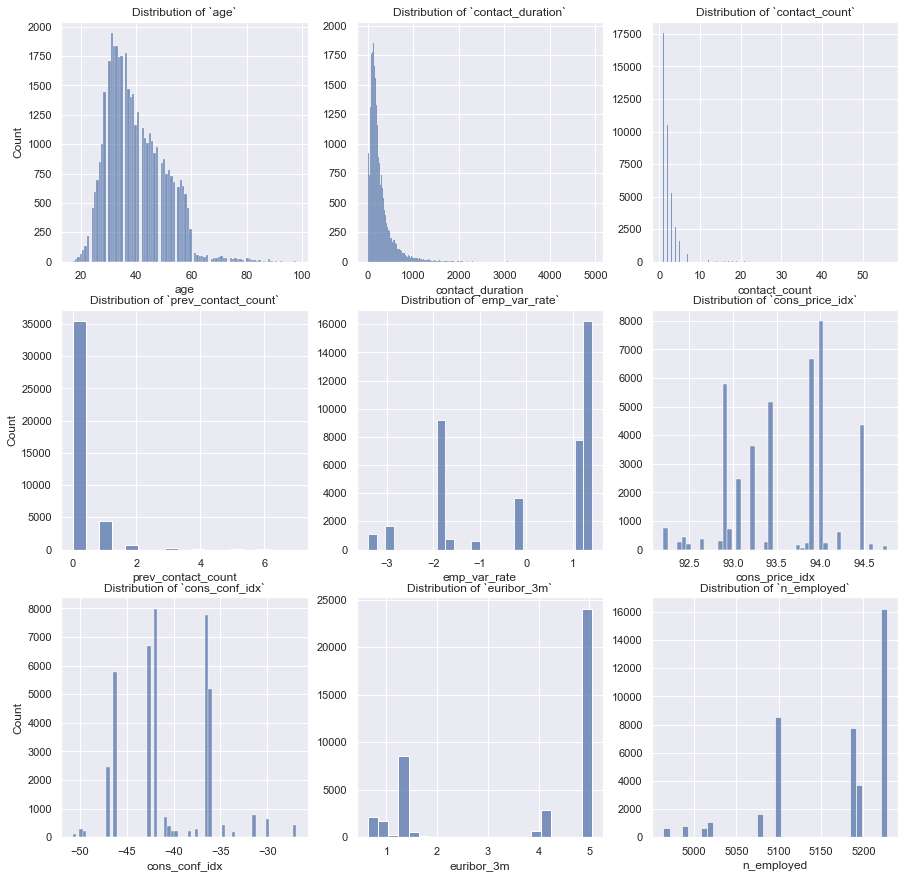

In [34]:
plotting.multi_dist(df[utils.true_numeric_cols(df)])

# MODEL

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE
# from imblearn.over_sampling import SMOTENC
import functools

## First Model

For my baseline model, I apply minimal preprocessing to the data. The first thing I do is ensure that all numeric features are in float format.

In [36]:
df[utils.numeric_cols(df)] = df.select_dtypes("number").astype(np.float64)

My initial preprocessing "pipeline" is really just a `ColumnTransformer` which one-hot encodes categorical variables with three or more categories. Recall that binary categoricals are already numerically encoded.

This pipeline essentially does no preprocessing at all other than the bare minimum required for multi-class categorical variables.

In [37]:
cat_xform = [
    ("onehot", OneHotEncoder(), utils.multicat_cols)
]
cat_xform = ColumnTransformer(cat_xform, remainder="passthrough", sparse_threshold=0)
cat_xform

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('onehot', OneHotEncoder(),
                                 <function multicat_cols at 0x000001C7AC5ACB80>)])

Here I apply preprocessing and perform a train-test split.

Notice that I simply drop all observations with missing values. This is arguably the crudest way to deal with them, and I want to start off crudely.

I drop "contact_duration", because as noted in on the [UCI Repo](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing) for this dataset, it reduces the practical value of the model. This was the duration of the last call, after which the broker knew whether or not the customer invested. The duration of the final call wouldn't be known prior to calling the customer. What should I tell the broker, "keep them on the line for longer than zero seconds?"

In [38]:
# drop NaNs and irrelevant columns
X = df.dropna().drop(columns=["invested", "contact_duration"])

# drop NaNs and slice target column
y = df.dropna()["invested"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((992, 18), (331, 18), (992,), (331,))

### Random Dummy Model
I create a dummy model which makes uniform random predictions. It's good to ensure that my models are better than an extremely dumb alternative. If the dummy model is good at all, it's due to pure luck.

I train the model on all features except the target.

The diagonal of the confusion matrix indicates that the dummy gets 51% of the true negatives and 48% of the true positives, which is pretty bad.

The ROC curve is not even a curve, because if falls directly on the 1:1 line, with 0.5 AUC. This is about the worst a model could do.

In [39]:
dummy_pipe = [
    ("cat_xform", cat_xform),
    ("dummy", DummyClassifier(strategy="uniform", random_state=63))
]
dummy_pipe = Pipeline(dummy_pipe)
dummy_pipe

Pipeline(steps=[('cat_xform',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('onehot', OneHotEncoder(),
                                                  <function multicat_cols at 0x000001C7AC5ACB80>)])),
                ('dummy',
                 DummyClassifier(random_state=63, strategy='uniform'))])

              precision    recall  f1-score   support

         0.0       0.45      0.61      0.52       133
         1.0       0.66      0.51      0.57       198

    accuracy                           0.55       331
   macro avg       0.56      0.56      0.55       331
weighted avg       0.58      0.55      0.55       331



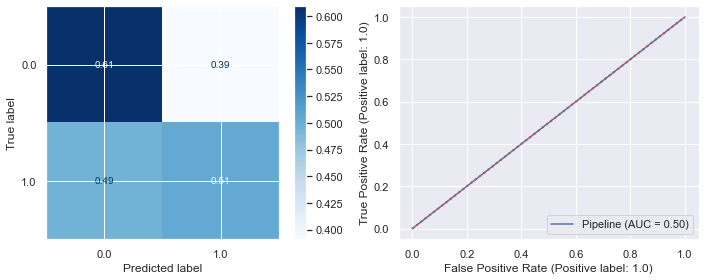

In [40]:
dummy_pipe.fit(X_train, y_train)
diagnostics.class_report(dummy_pipe, X_test, y_test)

### Baseline Logistic Regression

My baseline model is surprisingly good, despite the minimal preprocessing. It's trained on all features except the target, completely ignoring potential multicollinearity issues.

One powerful feature of the `LogisticRegression` estimator is the `class_weight="balanced"` setting, which adjusts the model to accommodate the very imbalanced (9:1) target classes.

The diagonal of the confusion matrix indicates that it gets ~88% of the labels correct. That's pretty good, and much better than `dummy_model`, which gets ~50% correct.

The ROC curve looks very good, and the Area Under Curve (AUC) is a solid 0.94.

In [41]:
logit_pipe = [
    ("cat_xform", cat_xform),
    ("logit", LogisticRegression(fit_intercept=False,
                                 C=1e12,
                                 multi_class="ovr",
                                 max_iter=1e4,
                                 class_weight="balanced",
                                 solver="liblinear"))
]
logit_pipe = Pipeline(logit_pipe)
logit_pipe

Pipeline(steps=[('cat_xform',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('onehot', OneHotEncoder(),
                                                  <function multicat_cols at 0x000001C7AC5ACB80>)])),
                ('logit',
                 LogisticRegression(C=1000000000000.0, class_weight='balanced',
                                    fit_intercept=False, max_iter=10000.0,
                                    multi_class='ovr', solver='liblinear'))])

              precision    recall  f1-score   support

         0.0       0.60      0.59      0.60       133
         1.0       0.73      0.74      0.73       198

    accuracy                           0.68       331
   macro avg       0.67      0.66      0.67       331
weighted avg       0.68      0.68      0.68       331



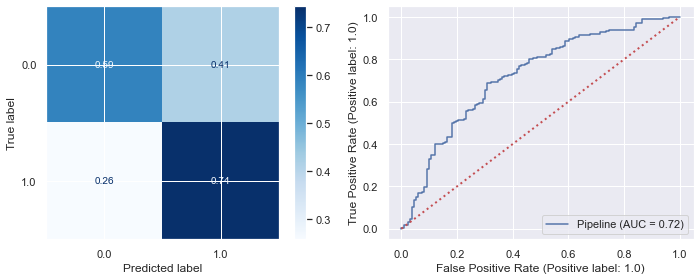

In [42]:
logit_pipe.fit(X_train, y_train)
diagnostics.class_report(logit_pipe, X_test, y_test)

Recall that the target classes have about a 9:1 ratio.

In [43]:
df["invested"].value_counts(1).round(2)

0.0    0.89
1.0    0.11
Name: invested, dtype: float64

In [44]:
logit_pipe["logit"].coef_

array([[-5.16308617e-02, -1.84740585e-01,  5.79916526e-02,
        -1.12951940e-01,  1.84662821e-01, -1.63526971e-01,
        -3.48185015e-01,  8.58495377e-02,  4.19462880e-01,
         3.79279177e-02,  6.70598279e-02,  1.75554940e-01,
        -2.98310687e-02, -1.53804607e-01,  3.94058853e-02,
        -2.93996561e-01, -1.59212503e-01,  1.75252574e-01,
         2.98985823e-01, -6.85159538e-02,  3.57752371e-01,
         2.26450583e-01, -1.62773948e-01, -2.48435624e-01,
         1.17267530e+00,  3.07147485e-01, -7.53311309e-01,
        -7.89804241e-01, -1.17781350e-01,  9.06005231e-02,
        -3.88668474e-01,  3.31650375e-01, -6.00541317e-02,
         1.83909721e-02,  9.84395470e-03, -2.63015405e-02,
         1.21611134e-01, -2.06124937e-01, -7.16842918e-02,
        -1.10061242e+00,  7.58863774e-01,  3.88286168e-04,
         8.08365916e-01, -1.48521924e-02,  6.66480607e-01,
         2.42745358e-01,  2.42890472e-01]])

## Second Model
### Preprocessing Enhancements

In [45]:
cat_pipe = Pipeline([
    ("mode_impute", SimpleImputer(strategy="most_frequent")), 
    ("onehot", OneHotEncoder()),
])
cat_pipe

Pipeline(steps=[('mode_impute', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder())])

In [46]:
col_xform = [
    ("cat_pipe", cat_pipe, utils.multicat_cols),
    ("scale", StandardScaler(), utils.true_numeric_cols),
]
col_xform = ColumnTransformer(col_xform, remainder='passthrough')
col_xform

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat_pipe',
                                 Pipeline(steps=[('mode_impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot', OneHotEncoder())]),
                                 <function multicat_cols at 0x000001C7AC5ACB80>),
                                ('scale', StandardScaler(),
                                 <function true_numeric_cols at 0x000001C7AC598CA0>)])

In [47]:
pre_pipe = Pipeline([
    ("col_xform", col_xform),
    ("knn_impute",  IterativeImputer()),
])

In [48]:
logit_pipe = Pipeline([
    ("pre_pipe", pre_pipe),
    ("logit", LogisticRegressionCV(fit_intercept=False,
                                 Cs=[1.0, 1e3, 1e6, 1e9, 1e12],
                                 multi_class="ovr",
                                 class_weight="balanced",
                                 solver="liblinear",
                                 n_jobs=-1))
])
logit_pipe

Pipeline(steps=[('pre_pipe',
                 Pipeline(steps=[('col_xform',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('cat_pipe',
                                                                   Pipeline(steps=[('mode_impute',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehot',
                                                                                    OneHotEncoder())]),
                                                                   <function multicat_cols at 0x000001C7AC5ACB80>),
                                                                  ('scale',
                                                                   StandardScaler(),
                                                                   <

In [49]:
# drop irrelevant columns
X = df.drop(columns=["invested"])

# slice target column
y = df["invested"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((30732, 19), (10244, 19), (30732,), (10244,))

              precision    recall  f1-score   support

         0.0       0.98      0.85      0.91      9129
         1.0       0.43      0.88      0.57      1115

    accuracy                           0.86     10244
   macro avg       0.70      0.87      0.74     10244
weighted avg       0.92      0.86      0.88     10244



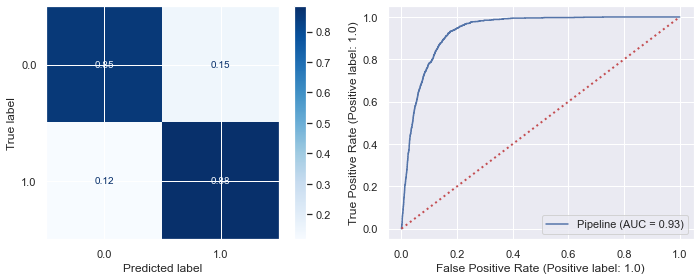

In [50]:
logit_pipe.fit(X_train, y_train)
diagnostics.class_report(logit_pipe, X_test, y_test)

In [51]:
impute_pipe = Pipeline([
    ("minmax", MinMaxScaler()),
    ("impute", KNNImputer()),
])
impute_pipe

Pipeline(steps=[('minmax', MinMaxScaler()), ('impute', KNNImputer())])

In [52]:
logit_pipe2 = Pipeline([
    ("minmax", StandardScaler()),
    ("impute", KNNImputer()),
    ("logit", LogisticRegression(fit_intercept=False,
                             C=1e12,
                             multi_class="ovr",
                             class_weight="balanced",
                             solver="liblinear"))
])

In [53]:
onehot_df = pd.get_dummies(df)
X = onehot_df.drop(columns=["invested", "contact_duration"])
y = onehot_df["invested"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

              precision    recall  f1-score   support

         0.0       0.95      0.79      0.86      9129
         1.0       0.28      0.67      0.39      1115

    accuracy                           0.78     10244
   macro avg       0.61      0.73      0.63     10244
weighted avg       0.88      0.78      0.81     10244



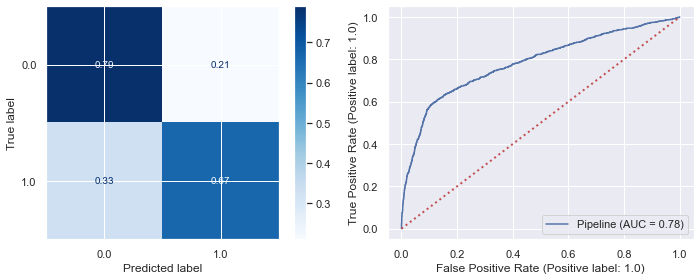

In [54]:
logit_pipe2.fit(X_train, y_train)
diagnostics.class_report(logit_pipe2, X_test, y_test)

In [55]:
imputed = impute_pipe.fit_transform(onehot_df)
imputed = pd.DataFrame(imputed, columns=onehot_df.columns, index=onehot_df.index)
imputed

KeyboardInterrupt: 

In [ ]:
sns.lineplot(data=imputed, x="contact_duration", y="invested")

# iNTERPRET

# CONCLUSIONS & RECOMMENDATIONS

> Summarize your conclusions and bullet-point your list of recommendations, which are based on your modeling results.

# TO DO/FUTURE WORK

- 